# ALS disease
Predicting ALS disease using emg signal with LSTM (Long short-term memory)


### import libraries

In [4]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

import EMGFilters as emg
import handleSignals as su

import numpy as np
from numpy import array
import pandas as pd
from keras.models import Sequential,load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional, TimeDistributed
from sklearn.metrics import mean_squared_error
from math import sqrt

### Dataset Input & Visualization

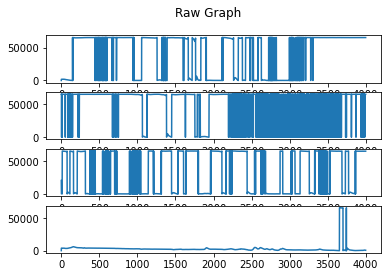

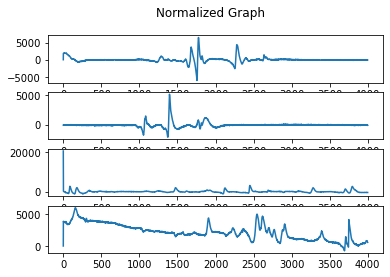

In [5]:
path_healthy = "./healthy"
path_als = "./als"
files_h = [f for f in listdir(path_healthy) if isfile(join(path_healthy, f))]
files_a = [f for f in listdir(path_als) if isfile(join(path_als, f))]

max_len = -1
data_h = [] # healthy data
data_a = [] # ALS data
dataH_norm = [] # normalized data
dataA_norm = []
filtered_h = []
filtered_a = []

max_val = -1
min_val = 1

filtering = emg.EMG_filter()

for each_h in files_h:
    file = open("./healthy/" + each_h, "rb")
    hexi = file.read(2)
    points = []
    points_norm = []
    while hexi:
        deci = int.from_bytes(hexi, byteorder='little')
        points.append(deci)
        deci = deci if deci < 32768 else deci - 65536 # using to normalization of the data
        points_norm.append(deci)
        hexi = file.read(2)
    if max_len > 0:
        points = points[:max_len]
    data_h.append(points)
    dataH_norm.append(points_norm)
    
    if max_val < max(points):
        max_val = max(points)
    if min_val > min(points):
        min_val = min(points)
    # filtered_h.append(filtering.filter(points)) # no effect, so commenting
    

for each_a in files_a:
    file = open("./als/" + each_a, "rb")
    hexi = file.read(2)
    points = []
    points_norm = []
    while hexi:
        deci = int.from_bytes(hexi, byteorder='little')
        points.append(deci)
        deci = deci if deci < 32768 else deci - 65536
        points_norm.append(deci)
        hexi = file.read(2)
    if max_len > 0:
        points = points[:max_len]
    data_a.append(points)
    dataA_norm.append(points_norm)

    if max_val < max(points):
        max_val = max(points)
    if min_val > min(points):
        min_val = min(points)


# print(data_h)
# print(files_a)

# draw raw data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.suptitle('Raw Graph')
ax1.plot(data_a[0][:4000])
ax2.plot(data_a[1][:4000])
ax3.plot(data_h[0][:4000])
ax4.plot(data_h[1][:4000])
plt.show()

# draw normalized data
fig_norm, (ax1_norm, ax2_norm, ax3_norm, ax4_norm) = plt.subplots(4)
fig_norm.suptitle('Normalized Graph')
ax1_norm.plot(dataA_norm[0][:4000])
ax2_norm.plot(dataA_norm[1][:4000])
ax3_norm.plot(dataH_norm[0][:4000])
ax4_norm.plot(dataH_norm[1][:4000])
plt.show()

### Global functions for deep learning model

In [6]:
# build a univariate sequence
def build_sequence(sequence, n_steps, symptom):
    # X, y = [], []
    for i in range(0, len(sequence), int(n_steps / 2)):
        end_index = i + n_steps
        # check if end index is over sequence
        if end_index + 1 > len(sequence):
            break
        # get input and output
        seq_x, seq_y = sequence[i:end_index], symptom
        X.append(seq_x)
        y.append(seq_y)

    # return array(X), array(y)

def split_series(series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end], series[past_end:future_end]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

### Traning Model

In [7]:
# past steps
n_steps = 40
# train test split percent
train_percent = 0.8
X, y = [],[]
for each_h  in data_h:
    build_sequence(each_h, n_steps, 1)
    
for each_a  in data_a:
    build_sequence(each_a, n_steps, 0)

X = array(X)
y = array(y)
# rescale data to range [-1, 1] which is suitable to tanh activation function
X = np.array(X / (max_val / 2) - 1)

n_features = 1
X = X.reshape(X.shape[0], X.shape[1], n_features)

train_size = int(len(X) * train_percent)
X_train, y_train = X[0:train_size], y[0:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# define model
model = Sequential()
model.add(Bidirectional(LSTM(512, activation='tanh', return_sequences=True), input_shape=(n_steps, n_features)))
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(X_train, y_train, epochs=100)

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("model loss.png")

model.save("BI-LSTM epoch-20.h5")

Epoch 1/100
1311/1311 [==============================] - 1260s 953ms/step - loss: 0.2271
Epoch 2/100
1311/1311 [==============================] - 1303s 994ms/step - loss: 0.2169
Epoch 3/100
1311/1311 [==============================] - 1228s 937ms/step - loss: 0.2141
Epoch 4/100
1311/1311 [==============================] - 1204s 918ms/step - loss: 0.2132
Epoch 5/100
1311/1311 [==============================] - 1246s 951ms/step - loss: 0.2127
Epoch 6/100
1311/1311 [==============================] - 1209s 923ms/step - loss: 0.2116
Epoch 7/100
1311/1311 [==============================] - 1167s 890ms/step - loss: 0.2324
Epoch 8/100
1311/1311 [==============================] - 1198s 914ms/step - loss: 0.2314
Epoch 9/100
1311/1311 [==============================] - 1128s 860ms/step - loss: 0.2310
Epoch 10/100
1311/1311 [==============================] - 1127s 859ms/step - loss: 0.2306
Epoch 11/100
1311/1311 [==============================] - 1123s 857ms/step - loss: 0.2295
Epoch 12/100
1311/1

### Prediction

In [ ]:
predictions = []
current_index = 0
for x_input in X_test:
    x_input = x_input.reshape(1, n_steps, n_features)
    yhat = model.predict(x_input)
    
    print("Real value: " + str(y_test[current_index]))
    print("predicted value: " + str(yhat))
    print('----------------------------------------------------------')
    predictions.append(yhat[0])

    current_index += 1

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    return mean_squared_error(actual, predicted , squared=True)


Real value: 0
predicted value: [[0.941175]]
----------------------------------------------------------
Real value: 0
predicted value: [[0.44143143]]
----------------------------------------------------------
Real value: 0
predicted value: [[0.9900344]]
----------------------------------------------------------
Real value: 0
predicted value: [[0.3881029]]
----------------------------------------------------------
Real value: 0
predicted value: [[0.03372282]]
----------------------------------------------------------
Real value: 0
predicted value: [[0.5117745]]
----------------------------------------------------------
Real value: 0
predicted value: [[0.3911378]]
----------------------------------------------------------
